In [1]:
import pandas as pd
import numpy as np
from datetime import timedelta
from tqdm import tqdm

d:\Anaconda\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
d:\Anaconda\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
icustays_file='../icustays.csv'
diagnoses_icd_file='../diagnoses_icd.csv'
diagnoses_icd_df=pd.read_csv(diagnoses_icd_file)
icustays_df=pd.read_csv(icustays_file)

In [3]:
diagnoses_icd = set(diagnoses_icd_df['subject_id'])
icustays = set(icustays_df['subject_id'])

# 计算交集
icu_ = list(diagnoses_icd.intersection(icustays))  #住进过icu的subject_id
icu_count=len(icu_)

In [4]:
id_df=pd.read_csv('output/Sepsis_Age_Gender.csv')

In [5]:
output_file='../outputevents.csv'
output_df=pd.read_csv(output_file)
#output_df=output_df[output_df['subject_id'].isin(icu_)]
#output_file = 'E:/mimic_data/outputevent.csv'
#output_df.to_csv(output_file,index=False)

In [6]:
# 根据 stay_id 进行内连接
output_df = pd.merge(output_df, id_df[['stay_id']], on='stay_id', how='inner')

In [7]:
urine_id = [226559, 226560, 226561, 226584, 226563, 226564, 226565, 226567, 226557, 226558, 227488, 227489]
output_df=output_df[output_df['itemid'].isin(urine_id)]
output_df['charttime'] = pd.to_datetime(output_df['charttime'])
positive_itemids = [226559, 226560, 226561, 226584, 226563, 226564, 226565, 226567, 226557, 226558, 227489]
negative_itemid = 227488
results = []
for stay_id, group in tqdm(output_df.groupby('stay_id')):
    min_charttime = group['charttime'].min()
    start_time = min_charttime + pd.Timedelta(hours=6)
    relevant_data = group[group['charttime'] >= start_time]
    subject_id = group.iloc[0]['subject_id']
    hadm_id = group.iloc[0]['hadm_id']
    for hour in pd.date_range(start=start_time.floor('H'), end=group['charttime'].max().ceil('H'), freq='H'):
        end_time = hour
        start_time_window = end_time - pd.Timedelta(hours=6)
        past_6_hours_data = group[(group['charttime'] >= start_time_window) & (group['charttime'] <= end_time)]
        if past_6_hours_data.shape[0] == 0:
            continue
        positive_values = past_6_hours_data[past_6_hours_data['itemid'].isin(positive_itemids)]['value'].sum()
        negative_values = past_6_hours_data[past_6_hours_data['itemid'] == negative_itemid]['value'].sum()
        urine_value = positive_values - negative_values
        results.append({'subject_id': subject_id, 'hadm_id': hadm_id, 'stay_id': stay_id, 'charttime': end_time, 'urine': urine_value})
urine_df = pd.DataFrame(results)

urine_df.head(10)#算尿量

  0%|          | 0/10680 [00:00<?, ?it/s]C:\Users\86136\AppData\Local\Temp\ipykernel_30804\1135784955.py:13: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  for hour in pd.date_range(start=start_time.floor('H'), end=group['charttime'].max().ceil('H'), freq='H'):
100%|██████████| 10680/10680 [14:21<00:00, 12.40it/s]


,subject_id,hadm_id,stay_id,charttime,urine
0,16513856,24463832,30001446,2186-04-12 11:00:00,240.0
1,16513856,24463832,30001446,2186-04-12 12:00:00,235.0
2,16513856,24463832,30001446,2186-04-12 13:00:00,165.0
3,16513856,24463832,30001446,2186-04-12 14:00:00,210.0
4,16513856,24463832,30001446,2186-04-12 15:00:00,170.0
5,16513856,24463832,30001446,2186-04-12 16:00:00,110.0
6,16513856,24463832,30001446,2186-04-12 17:00:00,230.0
7,16513856,24463832,30001446,2186-04-12 18:00:00,195.0
8,16513856,24463832,30001446,2186-04-12 19:00:00,305.0
9,16513856,24463832,30001446,2186-04-12 20:00:00,380.0


In [8]:
urine_df['urine_flag'] = urine_df['urine'].apply(lambda x: 1 if x <= 150 else 0)
urine_df = urine_df.sort_values(by=['stay_id', 'charttime'])
urine_df['flag_change'] = urine_df.groupby('stay_id')['urine_flag'].diff().ne(0)
urine_df['flag_change'] = urine_df['flag_change'] | urine_df.groupby('stay_id')['flag_change'].transform(lambda x: x.iloc[0] | pd.Series([True]))
urine_save = urine_df[urine_df['flag_change']].drop(columns=['flag_change'])
urine_save = urine_save.rename(columns={'urine_flag': 'low_urine'})
urine_save.to_csv('output/urine.csv', index=False)
print("The file 'urine.csv' has been saved successfully.")#从正常尿量转向低尿量事件和低尿量转向正常尿量事件，包括每次住院记录的第一条数据
#urine_save数据在urine.csv文件中

The file 'urine.csv' has been saved successfully.


In [9]:
nromal_dict = {220045: [60, 100], 220050: [90, 140], 220052: [60, 100], 220051: [60, 90], 220210: [12, 16],
                226253: [-999, 90], 223762: [36, 38.3], 227464: [3.5, 5.2], 226534: [135, 145], 226536: [96, 106],
                226537: [-999, 99], 225624: [6, 24], 229761: [0.74, 1.35, 0.59, 1.04], 220635: [1.7, 2.2],
                225667: [1.2, 1.4], 220235: [35, 45], 225690: [0.1, 1.2], 227456: [3.4, 5.4], 220228: [13.8, 17.2, 12.1, 15.1],
                220546: [5, 10], 227457: [140, 400], 227466: [25, 35], 227465: [11, 13.5], 227467: [0.8, 1.1],
                223830: [7.38, 7.42], 226063: [75, 100], 224828: [-2, 2], 225668: [-999, 2]}
item_set, special_item = [], []
for item_id in nromal_dict:
    item_set.append(item_id)
    if len(nromal_dict[item_id]) == 4:
        special_item.append(item_id)#在icu中的检测数据

In [10]:
urine_save_file='output/urine.csv'
urine_save=pd.read_csv(urine_save_file)

In [12]:
chartevent_file = '../chartevents.csv'
chunk_size = 10**6  

# 创建一个空 DataFrame
chartevent_df = pd.DataFrame()

# 读取数据块
for chunk in pd.read_csv(chartevent_file, chunksize=chunk_size):
    chartevent_df = pd.concat([chartevent_df, chunk], ignore_index=True)

MemoryError: Unable to allocate 1.22 GiB for an array with shape (1, 164000000) and data type float64

: 

In [10]:
chartevent_df

,subject_id,hadm_id,stay_id,caregiver_id,charttime,storetime,itemid,value,valuenum,valueuom,warning
0,10002013,23581541,39060235,4030.0,2160-05-18 14:00:00,2160-05-18 14:19:00,223835,100,100.0,NaN,0.0
1,10002013,23581541,39060235,4030.0,2160-05-18 14:00:00,2160-05-18 14:19:00,223848,Drager,1.0,NaN,0.0
2,10002013,23581541,39060235,4030.0,2160-05-18 14:00:00,2160-05-18 14:19:00,223849,CMV/ASSIST,2.0,NaN,0.0
3,10002013,23581541,39060235,4030.0,2160-05-18 14:00:00,2160-05-18 14:19:00,226732,Endotracheal tube,NaN,NaN,0.0
4,10002013,23581541,39060235,4030.0,2160-05-18 14:00:00,2160-05-18 14:20:00,220339,5,5.0,cmH2O,0.0
...,...,...,...,...,...,...,...,...,...,...,...
70306092,19997367,21508795,36980198,NaN,2127-04-06 03:03:00,2127-04-06 04:10:00,225625,9,9.0,mg/dL,0.0
70306093,19997367,21508795,36980198,NaN,2127-04-06 03:03:00,2127-04-06 04:10:00,225677,3.4,3.4,mg/dL,0.0
70306094,19997367,21508795,36980198,NaN,2127-04-06 03:03:00,2127-04-06 04:10:00,227073,12,12.0,mEq/L,0.0
70306095,19997367,21508795,36980198,NaN,2127-04-06 03:03:00,2127-04-06 04:10:00,227442,4,4.0,mEq/L,0.0


In [20]:
low_urine_df = urine_save[urine_save['low_urine']==1].copy()#找到低尿量事件
icustays=pd.read_csv('../icustays.csv')
#icu_是有脓毒症还进过icu的名单
stay_id_df=icustays[icustays['subject_id'].isin(icu_)]#有脓毒症还进过icu的患者名单
stay_id_set = icustays[icustays['subject_id'].isin(icu_)]['stay_id'].unique()#有脓毒症还进过icu的患者stay_id
sepsis_chart = chartevent_df[(chartevent_df['stay_id'].isin(stay_id_set)) & (chartevent_df['itemid'].isin(item_set))]
sepsis_chart['charttime'] = pd.to_datetime(sepsis_chart['charttime'])
low_urine_df['charttime'] = pd.to_datetime(low_urine_df['charttime'])
stay_id_df['intime']=pd.to_datetime(stay_id_df['intime'])
stay_id_df['outtime']=pd.to_datetime(stay_id_df['outtime'])

C:\Users\王泓烨\AppData\Local\Temp\ipykernel_3044\2457246033.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sepsis_chart['charttime'] = pd.to_datetime(sepsis_chart['charttime'])
C:\Users\王泓烨\AppData\Local\Temp\ipykernel_3044\2457246033.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stay_id_df['intime']=pd.to_datetime(stay_id_df['intime'])
C:\Users\王泓烨\AppData\Local\Temp\ipykernel_3044\2457246033.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

In [21]:
deadevent=pd.read_csv('../addmission.csv')
deadevent=deadevent[deadevent['subject_id'].isin(icu_)]
deadevent = deadevent[deadevent['deathtime'].notna()& (deadevent['deathtime'] != "")]#所有有死亡信息的患者
deadevent = deadevent.rename(columns={'deathtime': 'charttime'})
columns_to_keep = ['subject_id', 'hadm_id', 'charttime']
deadevent=deadevent[columns_to_keep]
deadevent['charttime']=pd.to_datetime(deadevent['charttime'])

In [23]:
urine_tpp_result = []
for index, row in tqdm(stay_id_df.iterrows(), total=stay_id_df.shape[0], desc="Processing stay_id"):
    stay_id = row['stay_id']
    end_time = row['outtime']
    start_time = row['intime']
    subject_id=row['subject_id']
    filtered_data = sepsis_chart.loc[(sepsis_chart['stay_id'] == stay_id) &
                                     (sepsis_chart['charttime'] >= start_time) &
                                     (sepsis_chart['charttime'] < end_time)].copy()
    filtered_data['time'] = (filtered_data['charttime'] - start_time).dt.total_seconds() / 3600
    filtered_data = filtered_data[['stay_id', 'itemid', 'time', 'value']]
    if filtered_data.empty:
        continue
    for _, f_row in filtered_data.iterrows():
        urine_tpp_result.append({
            'stay_id': f_row['stay_id'],
            'itemid': f_row['itemid'],
            'time': f_row['time'],
            'value': f_row['value']
        })
    filtered_y = low_urine_df.loc[(low_urine_df['stay_id'] == stay_id) &
                                  (low_urine_df['charttime'] >= start_time) &
                                  (low_urine_df['charttime'] <= end_time)].copy()
    filtered_y['time'] = (filtered_y['charttime'] - start_time).dt.total_seconds() / 3600
    filtered_y = filtered_y[['time']]
    for _, f_row in filtered_y.iterrows():
        urine_tpp_result.append({
            'stay_id': stay_id,
            'itemid': 0,
            'time': f_row['time'],
            'value': 1
        })
    filtered_z=deadevent.loc[(deadevent['subject_id']==subject_id)&(deadevent['charttime'] >= start_time) &
                                  (deadevent['charttime'] <= end_time)].copy()#在住院期间内，就说明是这次住院发生的事件
    filtered_z['time'] = (filtered_z['charttime'] - start_time).dt.total_seconds() / 3600
    if filtered_z.empty:
        continue
    for _, f_row in filtered_z.iterrows():
        urine_tpp_result.append({
            'stay_id': stay_id,
            'itemid': 1,
            'time': f_row['time'],
            'value': 1
        })
urine_tpp = pd.DataFrame(urine_tpp_result)
urine_tpp.head()
urine_tpp['time'] = urine_tpp['time'].round(6)

Processing stay_id: 100%|██████████████████████████████████████████████████████████████████████████████████████| 12144/12144 [12:58<00:00, 15.59it/s]


In [24]:
urine_tpp.to_csv('output/urine_tpp_all.csv', index=False)
print("The file 'urine_tpp_all.csv' has been saved successfully.")

The file 'urine_tpp_all.csv' has been saved successfully.


In [25]:
urine_tpp = pd.read_csv('output/urine_tpp_all.csv')#是chartevent中的信息+低尿量事件+死亡事件
urine_tpp

,stay_id,itemid,time,value
0,39060235,220045,9.985278,103.0
1,39060235,220050,9.985278,116.0
2,39060235,220051,9.985278,75.0
3,39060235,220052,9.985278,89.0
4,39060235,220210,9.985278,18.0
...,...,...,...,...
5843266,36980198,0,40.217778,1.0
5843267,36980198,0,80.217778,1.0
5843268,36980198,0,88.217778,1.0
5843269,36980198,0,92.217778,1.0


In [27]:
itemid_1_rows = urine_tpp[urine_tpp['itemid'] == 1]
itemid_1_rows

,stay_id,itemid,time,value
5447,39699336,1,312.900000,1.0
15564,39558308,1,29.183333,1.0
20203,39381825,1,3.724167,1.0
27930,36460006,1,209.301667,1.0
31354,39061571,1,115.213333,1.0
...,...,...,...,...
5804971,30198261,1,196.093611,1.0
5816360,33533600,1,50.722778,1.0
5832204,31169972,1,11.365833,1.0
5833248,33542287,1,22.250000,1.0


In [16]:
icustays=pd.read_csv('../icustays.csv')
patients=pd.read_csv('../patients.csv')

In [17]:
urine_tpp = urine_tpp.merge(icustays[['stay_id', 'subject_id']], on='stay_id', how='left')
urine_tpp = urine_tpp.merge(patients[['subject_id', 'gender','anchor_age']], on='subject_id', how='left')
urine_tpp['abnormal'] = 1
for itemid, normal_range in tqdm(nromal_dict.items()):
    if itemid not in special_item:
        mask = (urine_tpp['itemid'] == itemid) & (urine_tpp['value'] >= normal_range[0]) & (urine_tpp['value'] <= normal_range[1])
        urine_tpp.loc[mask, 'abnormal'] = 0
for itemid in tqdm(special_item):
    normal_range = nromal_dict[itemid]
    male_mask = (urine_tpp['itemid'] == itemid) & (urine_tpp['gender'] == 'M') & (urine_tpp['value'] >= normal_range[0]) & (urine_tpp['value'] <= normal_range[1])
    female_mask = (urine_tpp['itemid'] == itemid) & (urine_tpp['gender'] == 'F') & (urine_tpp['value'] >= normal_range[2]) & (urine_tpp['value'] <= normal_range[3])
    urine_tpp.loc[male_mask, 'abnormal'] = 0
    urine_tpp.loc[female_mask, 'abnormal'] = 0
urine_tpp = urine_tpp.rename(columns={'anchor_age': 'age'})

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.78it/s]


In [18]:
urine_tpp

,stay_id,itemid,time,value,subject_id,gender,age,abnormal
0,30000484,220045,38.633333,106.0,18421337,M,91,1
1,30000484,220210,38.633333,22.0,18421337,M,91,1
2,30000484,226253,38.683333,85.0,18421337,M,91,0
3,30000484,220045,39.000000,99.0,18421337,M,91,0
4,30000484,220210,39.000000,16.0,18421337,M,91,0
...,...,...,...,...,...,...,...,...
3194059,39999230,220635,32.633333,2.0,13651601,M,49,0
3194060,39999230,225624,32.633333,35.0,13651601,M,49,1
3194061,39999230,225690,32.633333,2.7,13651601,M,49,1
3194062,39999230,227456,32.633333,3.4,13651601,M,49,0


In [19]:
urine_tpp = urine_tpp.sort_values(by=['stay_id', 'itemid', 'time'])
urine_tpp['abnormal_diff'] = urine_tpp.groupby(['stay_id', 'itemid'])['abnormal'].diff().fillna(1)
abnormal_rows = urine_tpp[(urine_tpp['abnormal'] == 1) & (urine_tpp['abnormal_diff'] != 0)]
abnormal_rows = abnormal_rows.drop(columns=['abnormal_diff'])

In [21]:
abnormal_rows#所有可以成为事件的数据

,stay_id,itemid,time,value,subject_id,gender,age,abnormal
197,30000484,0,8.000000,1.0,18421337,M,91,1
154,30000484,220045,26.000000,105.0,18421337,M,91,1
28,30000484,220045,35.633333,106.0,18421337,M,91,1
0,30000484,220045,38.633333,106.0,18421337,M,91,1
129,30000484,220210,2.000000,18.0,18421337,M,91,1
...,...,...,...,...,...,...,...,...
3193776,39999230,226537,17.233333,863.0,13651601,M,49,1
3193777,39999230,227464,17.233333,3.3,13651601,M,49,1
3193398,39999230,227465,11.616667,19.1,13651601,M,49,1
3193399,39999230,227466,11.616667,38.9,13651601,M,49,1


In [22]:
row_counts = abnormal_rows.groupby('stay_id').size()
data = row_counts.tolist()
bins = range(0, 150, 10)
categories = pd.cut(data, bins)
counts = categories.value_counts().sort_index()
print(counts)

(0, 10]        872
(10, 20]      1631
(20, 30]       808
(30, 40]       448
(40, 50]       336
(50, 60]       228
(60, 70]       185
(70, 80]       138
(80, 90]       124
(90, 100]      111
(100, 110]      92
(110, 120]      86
(120, 130]      80
(130, 140]      73
Name: count, dtype: int64


In [23]:
stay_id_counts = abnormal_rows['stay_id'].value_counts()
filtered_stay_ids = stay_id_counts[(stay_id_counts > 20) & (stay_id_counts <= 30)].index
filtered_abnormal_rows = abnormal_rows[abnormal_rows['stay_id'].isin(filtered_stay_ids)]
filtered_abnormal_rows = filtered_abnormal_rows.drop(columns=['subject_id','gender','age','abnormal'])
filtered_abnormal_rows

,stay_id,itemid,time,value
197,30000484,0,8.000000,1.0
154,30000484,220045,26.000000,105.0
28,30000484,220045,35.633333,106.0
0,30000484,220045,38.633333,106.0
129,30000484,220210,2.000000,18.0
...,...,...,...,...
3183823,39959902,227456,28.750000,2.7
3183816,39959902,227457,28.750000,102.0
3183817,39959902,227465,28.750000,15.1
3183834,39959902,227466,39.150000,45.5


In [25]:
d_items=pd.read_csv('../d_items.csv')

In [27]:
unique_stay_ids = filtered_abnormal_rows['stay_id'].unique()
item_label_dict = {row['itemid']: row['label'].replace(' ', '_') for index, row in d_items.iterrows() if row['itemid'] in item_set}
item_label_dict[0] = 'low_urine'
item_label_dict[1]='dead'
new_item_set = item_set.copy()
new_item_set.append(0)#手动添加一个itemid为0，标签为低尿量
new_item_set.append(1)

In [28]:
data_disc = {}  # Discrete values
for stay_id in tqdm(unique_stay_ids):
    data_disc[stay_id] = {}
    for itemid in new_item_set:
        item_label = item_label_dict[itemid]
        data_disc[stay_id][item_label] = {'time': [], 'state': []}
        filtered_data = filtered_abnormal_rows[(filtered_abnormal_rows['stay_id'] == stay_id) & 
                                               (filtered_abnormal_rows['itemid'] == itemid)]
        if not filtered_data.empty:
            data_disc[stay_id][item_label]['time'] = filtered_data['time'].tolist()
            data_disc[stay_id][item_label]['state'] = [1]*filtered_data.shape[0]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 808/808 [00:08<00:00, 97.24it/s]


In [29]:
data_cont = {} # Continuous values
for stay_id in tqdm(unique_stay_ids):
    data_cont[stay_id] = {}
    for itemid in new_item_set:
        item_label = item_label_dict[itemid]
        data_cont[stay_id][item_label] = {'time': [], 'value': []}
        filtered_data = filtered_abnormal_rows[(filtered_abnormal_rows['stay_id'] == stay_id) & 
                                               (filtered_abnormal_rows['itemid'] == itemid)]
        if not filtered_data.empty:
            data_cont[stay_id][item_label]['time'] = filtered_data['time'].tolist()
            data_cont[stay_id][item_label]['value'] = filtered_data['value'].tolist()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 808/808 [00:08<00:00, 95.45it/s]


In [30]:
first_key = next(iter(data_cont))
data_cont[first_key]

{'Heart_Rate': {'time': [26.0, 35.633333, 38.633333],
  'value': [105.0, 106.0, 106.0]},
 'Arterial_Blood_Pressure_systolic': {'time': [], 'value': []},
 'Arterial_Blood_Pressure_mean': {'time': [], 'value': []},
 'Arterial_Blood_Pressure_diastolic': {'time': [], 'value': []},
 'Respiratory_Rate': {'time': [2.0,
   5.0,
   10.0,
   14.0,
   20.0,
   23.0,
   36.0,
   38.0,
   39.0,
   40.0,
   41.0,
   43.0,
   44.0,
   46.0,
   47.0],
  'value': [18.0,
   17.0,
   19.0,
   11.0,
   21.0,
   17.0,
   19.0,
   17.0,
   18.0,
   18.0,
   17.0,
   24.0,
   18.0,
   20.0,
   19.0]},
 'SpO2_Desat_Limit': {'time': [], 'value': []},
 'Temperature_Celsius': {'time': [], 'value': []},
 'Potassium_(whole_blood)': {'time': [], 'value': []},
 'Sodium_(whole_blood)': {'time': [], 'value': []},
 'Chloride_(whole_blood)': {'time': [], 'value': []},
 'Glucose_(whole_blood)': {'time': [], 'value': []},
 'BUN': {'time': [8.466667], 'value': [47.0]},
 'Creatinine_(whole_blood)': {'time': [], 'value': []}

In [32]:
np.save('output/data_sepsis_disc_2030.npy', data_disc)
np.save('output/data_sepsis_cont_2030.npy', data_cont)


In [3]:
import pandas as pd

# 读取 Sepsis_Normal_Value.csv 文件
sepsis_normal_data = pd.read_csv('output/Sepsis_Normal_Value.csv', header=None)

# 提取 itemid 列
itemid_list = sepsis_normal_data[0].tolist()

# 列出 itemid
print(itemid_list)

['itemid', '220045', '220050', '220052', '220051', '220210', '226253', '223762', '227464', '226534', '226536', '226537', '225624', '229761', '220635', '225667', '220235', '225690', '227456', '220228', '220546', '227457', '227466', '227465', '227467', '223830', '226063', '224828', '225668', '227443', '225636', '227444', '220644', '227468', '220644', '220587']


In [6]:
import pandas as pd
from tqdm import tqdm

# 读取 Sepsis_Age_Gender.csv 文件，提取 stay_id
sepsis_age_gender = pd.read_csv('output/Sepsis_Age_Gender.csv')
valid_stay_ids = set(sepsis_age_gender['stay_id'])

# 定义需要保留的 itemid 列表
valid_itemids = {
    220045, 220050, 220052, 220051, 220210, 226253, 223762, 227464, 
    226534, 226536, 226537, 225624, 229761, 220635, 225667, 220235, 
    225690, 227456, 220228, 220546, 227457, 227466, 227465, 227467, 
    223830, 226063, 224828, 225668, 227443, 225636, 227444, 220644, 
    227468, 220587
}

# 读取 chartevents.csv 文件
chunk_size = 10**5  # 分块大小
filtered_data = pd.DataFrame()  # 用于存储过滤后的数据

# 计算块数
total_chunks = sum(1 for _ in pd.read_csv('..\chartevents.csv', chunksize=chunk_size))

# 使用 tqdm 显示进度条
with tqdm(total=total_chunks, desc="Processing chartevents") as pbar:
    for chunk in pd.read_csv('..\chartevents.csv', chunksize=chunk_size):
        # 过滤条件：stay_id 在 valid_stay_ids 中，itemid 在 valid_itemids 中
        filtered_chunk = chunk[(chunk['stay_id'].isin(valid_stay_ids)) & (chunk['itemid'].isin(valid_itemids))]
        filtered_data = pd.concat([filtered_data, filtered_chunk], ignore_index=True)
        pbar.update(1)

# 保存结果到 Targets_Raw.csv
output_file_path_targets_raw = 'output/Sepsis_Targets_Raw.csv'
filtered_data.to_csv(output_file_path_targets_raw, index=False)

print(f"Sepsis_Targets_Raw.csv 文件已保存到 {output_file_path_targets_raw}")

Processing chartevents: 100%|██████████| 4330/4330 [18:28<00:00,  3.91it/s]


Sepsis_Targets_Raw.csv 文件已保存到 output/Sepsis_Targets_Raw.csv


In [10]:
import pandas as pd

# 读取 Sepsis_Targets_Raw.csv 文件
sepsis_targets_raw = pd.read_csv('output/Sepsis_Targets_Raw.csv')

# 读取 Sepsis_Age_Gender.csv 文件
sepsis_age_gender = pd.read_csv('output/Sepsis_Age_Gender.csv')

# 合并两个 DataFrame，基于 subject_id
sepsis_targets_raw = sepsis_targets_raw.merge(sepsis_age_gender[['subject_id', 'gender']], on='subject_id', how='left')

# 保存结果到 Sepsis_Targets_Raw.csv，覆盖原表
output_file_path_sepsis_targets_raw = 'output/Sepsis_Targets_Raw.csv'
sepsis_targets_raw.to_csv(output_file_path_sepsis_targets_raw, index=False)

print(f"Sepsis_Targets_Raw.csv 文件已更新并保存到 {output_file_path_sepsis_targets_raw}")

Sepsis_Targets_Raw.csv 文件已更新并保存到 output/Sepsis_Targets_Raw.csv


In [11]:
import pandas as pd
from tqdm import tqdm

# 读取 Sepsis_Normal_Value.csv 文件
normal_values = pd.read_csv('output/Sepsis_Normal_Value.csv')

# 将 normal_values 转换为字典，方便查找
normal_values_dict = normal_values.set_index('itemid').T.to_dict()

# 读取 Sepsis_Targets_Raw.csv 文件
sepsis_targets_raw = pd.read_csv('output/Sepsis_Targets_Raw.csv')

# 删除不需要的列
columns_to_drop = ['subject_id', 'hadm_id', 'caregiver_id', 'storetime', 'valuenum', 'valueuom', 'warning']
sepsis_targets_raw.drop(columns=columns_to_drop, inplace=True)

# 增加 tag 和 label 列
tags = []
labels = []

# 使用 tqdm 显示进度条
for _, row in tqdm(sepsis_targets_raw.iterrows(), total=sepsis_targets_raw.shape[0], desc="Processing rows"):
    itemid = row['itemid']
    value = row['value']
    gender = row['gender']
    
    # 获取 normal value 信息
    normal_info = normal_values_dict.get(itemid, None)
    
    if normal_info:
        # 获取标签
        label = normal_info['label']
        labels.append(label)
        
        # 根据性别判断 tag
        if gender == 'M':
            if normal_info['M_Low'] <= value <= normal_info['M_High']:
                tags.append('normal')
            elif value < normal_info['M_Low']:
                tags.append('Low')
            else:
                tags.append('High')
        elif gender == 'F':
            if normal_info['F_Low'] <= value <= normal_info['F_High']:
                tags.append('normal')
            elif value < normal_info['F_Low']:
                tags.append('Low')
            else:
                tags.append('High')
        else:
            tags.append('unknown')  # 如果性别未知
            labels.append('unknown')  # 如果性别未知
    else:
        tags.append('unknown')  # 如果 itemid 未找到
        labels.append('unknown')  # 如果 itemid 未找到

# 将 tag 和 label 列添加到 DataFrame
sepsis_targets_raw['tag'] = tags
sepsis_targets_raw['label'] = labels

# 删除 tag 值为 normal 的行
sepsis_targets_raw = sepsis_targets_raw[sepsis_targets_raw['tag'] != 'normal']

# 保存结果到 Sepsis_Targets_Tag.csv
output_file_path_sepsis_targets_tag = 'output/Sepsis_Targets_Tag.csv'
sepsis_targets_raw.to_csv(output_file_path_sepsis_targets_tag, index=False)

print(f"Sepsis_Targets_Tag.csv 文件已保存到 {output_file_path_sepsis_targets_tag}")

C:\Users\86136\AppData\Local\Temp\ipykernel_14316\924784668.py:8: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  normal_values_dict = normal_values.set_index('itemid').T.to_dict()
Processing rows: 100%|██████████| 6552687/6552687 [03:54<00:00, 27971.68it/s]


Sepsis_Targets_Tag.csv 文件已保存到 output/Sepsis_Targets_Tag.csv


In [12]:
import pandas as pd
from tqdm import tqdm

# 读取 Sepsis_Targets_Tag.csv 文件
sepsis_targets_tag = pd.read_csv('output/Sepsis_Targets_Tag.csv')

# 读取 Sepsis_Age_Gender.csv 文件以获取 intime
sepsis_age_gender = pd.read_csv('output/Sepsis_Age_Gender.csv')

# 创建一个字典以便快速查找 stay_id 对应的 intime
intime_dict = sepsis_age_gender.set_index('stay_id')['intime'].to_dict()

# 删除 gender 列
sepsis_targets_tag.drop(columns=['gender'], inplace=True)

# 合并 tag 和 label 列为 event 列
sepsis_targets_tag['event'] = sepsis_targets_tag.apply(
    lambda row: f"{row['label']} {row['tag']}" if row['label'] and row['tag'] else 'unknown', axis=1
)

# 删除 tag 和 label 列
sepsis_targets_tag.drop(columns=['tag', 'label'], inplace=True)

# 添加 intime 列
sepsis_targets_tag['intime'] = sepsis_targets_tag['stay_id'].map(intime_dict)

# 保存结果到 Sepsis_Event_Raw.csv
output_file_path_sepsis_event_raw = 'output/Sepsis_Event_Raw.csv'
sepsis_targets_tag.to_csv(output_file_path_sepsis_event_raw, index=False)

print(f"Sepsis_Event_Raw.csv 文件已保存到 {output_file_path_sepsis_event_raw}")

Sepsis_Event_Raw.csv 文件已保存到 output/Sepsis_Event_Raw.csv


In [14]:
import pandas as pd
from tqdm import tqdm

# 读取 Sepsis_Event_Raw.csv 文件
sepsis_event_raw = pd.read_csv('output/Sepsis_Event_Raw.csv')

# 将 stay_id 列重命名为 id
sepsis_event_raw.rename(columns={'stay_id': 'id'}, inplace=True)

# 计算 t 列，charttime 和 intime 转换为 datetime 格式
sepsis_event_raw['charttime'] = pd.to_datetime(sepsis_event_raw['charttime'])
sepsis_event_raw['intime'] = pd.to_datetime(sepsis_event_raw['intime'])
sepsis_event_raw['t'] = (sepsis_event_raw['charttime'] - sepsis_event_raw['intime']).dt.total_seconds() / 3600

# 删除 t 值小于 0 的行
sepsis_event_raw = sepsis_event_raw[sepsis_event_raw['t'] >= 0]

# 重命名 value 列为 v，event 列为 k
sepsis_event_raw.rename(columns={'value': 'v', 'event': 'k'}, inplace=True)

# 按照 id 从小到大排序，如果 id 相同则按照 t 从小到大排序
sepsis_event_raw.sort_values(by=['id', 't'], inplace=True)

# 选择需要的列
sepsis_targets_four = sepsis_event_raw[['id', 't', 'v', 'k']]

# 保存结果到 Sepsis_Targets_Four.csv
output_file_path_sepsis_targets_four = 'output/Sepsis_Targets_Four.csv'
sepsis_targets_four.to_csv(output_file_path_sepsis_targets_four, index=False)

print(f"Sepsis_Targets_Four.csv 文件已保存到 {output_file_path_sepsis_targets_four}")

Sepsis_Targets_Four.csv 文件已保存到 output/Sepsis_Targets_Four.csv


In [15]:
import pandas as pd

# 读取 Sepsis_Targets_Four.csv 文件
sepsis_targets_four = pd.read_csv('output/Sepsis_Targets_Four.csv')

# 保留连续相同 k 值的第一行
sepsis_targets_unique = sepsis_targets_four.loc[sepsis_targets_four['k'].shift() != sepsis_targets_four['k']]

# 保存结果到 Sepsis_Targets_Unique.csv
output_file_path_sepsis_targets_unique = 'output/Sepsis_Targets_Unique.csv'
sepsis_targets_unique.to_csv(output_file_path_sepsis_targets_unique, index=False)

print(f"Sepsis_Targets_Unique.csv 文件已保存到 {output_file_path_sepsis_targets_unique}")

Sepsis_Targets_Unique.csv 文件已保存到 output/Sepsis_Targets_Unique.csv


In [16]:
import pandas as pd

# 读取 Sepsis_Targets_Unique.csv 文件
sepsis_targets_unique = pd.read_csv('output/Sepsis_Goal_Raw.csv')

# 将 stay_id 列重命名为 id
sepsis_targets_unique.rename(columns={'stay_id': 'id'}, inplace=True)

# 计算 t 列，charttime 和 intime 转换为 datetime 格式
sepsis_targets_unique['charttime'] = pd.to_datetime(sepsis_targets_unique['charttime'])
sepsis_targets_unique['intime'] = pd.to_datetime(sepsis_targets_unique['intime'])
sepsis_targets_unique['t'] = (sepsis_targets_unique['charttime'] - sepsis_targets_unique['intime']).dt.total_seconds() / 3600

# 将 urine 列重命名为 v
sepsis_targets_unique.rename(columns={'urine': 'v'}, inplace=True)

# 添加 k 列，所有行的 k 值为 'Low Urine'
sepsis_targets_unique['k'] = 'Low Urine'

# 选择需要的列
sepsis_goal_unique = sepsis_targets_unique[['id', 't', 'v', 'k']]

# 保存结果到 Sepsis_Goal_Unique.csv
output_file_path_sepsis_goal_unique = 'output/Sepsis_Goal_Unique.csv'
sepsis_goal_unique.to_csv(output_file_path_sepsis_goal_unique, index=False)

print(f"Sepsis_Goal_Unique.csv 文件已保存到 {output_file_path_sepsis_goal_unique}")

Sepsis_Goal_Unique.csv 文件已保存到 output/Sepsis_Goal_Unique.csv


In [18]:
import pandas as pd

# 读取 Sepsis_Goal_Unique.csv 文件
sepsis_goal_unique = pd.read_csv('output/Sepsis_Goal_Unique.csv')

# 提取唯一的 id
unique_ids = sepsis_goal_unique['id'].unique()

# 将唯一的 id 转换为 DataFrame
unique_ids_df = pd.DataFrame(unique_ids, columns=['id'])

# 保存为 Useful_Id1.csv
output_file_path = 'output/Useful_Id1.csv'
unique_ids_df.to_csv(output_file_path, index=False)

print(f"Unique IDs 已保存到 {output_file_path}")

Unique IDs 已保存到 output/Useful_Id1.csv


In [19]:
import pandas as pd

# 读取 Sepsis_Targets_Unique.csv 文件
sepsis_targets_unique = pd.read_csv('output/Sepsis_Targets_Unique.csv')

# 提取 id
unique_ids = sepsis_targets_unique['id'].unique()

# id 转换为 DataFrame
unique_ids_df = pd.DataFrame(unique_ids, columns=['id'])

# 保存为 Useful_Id2.csv
unique_ids_df.to_csv('output/Useful_Id2.csv', index=False)

print("已保存到 Useful_Id2.csv")

已保存到 Useful_Id2.csv


In [20]:
import pandas as pd

# 读取两个 CSV 文件
useful_id1 = pd.read_csv('output/Useful_Id1.csv', header=None, names=['id'])
useful_id2 = pd.read_csv('output/Useful_Id2.csv')

# 将 id 列转换为字符串类型，以确保数据类型一致
useful_id1['id'] = useful_id1['id'].astype(str)
useful_id2['id'] = useful_id2['id'].astype(str)

# 找到公共的 id
common_ids = pd.merge(useful_id1, useful_id2, on='id')

# 保存结果到 Useful_ID.csv
common_ids.to_csv('output/Useful_ID.csv', index=False)

print("公共的 id 已保存到 Useful_ID.csv")

公共的 id 已保存到 Useful_ID.csv


In [21]:
import pandas as pd
from tqdm import tqdm

# 读取 Useful_ID.csv
useful_ids = pd.read_csv('output/Useful_ID.csv')

# 读取 Sepsis_Goal_Unique.csv
sepsis_goal_unique = pd.read_csv('output/Sepsis_Goal_Unique.csv')

# 读取 Sepsis_Targets_Unique.csv
sepsis_targets_unique = pd.read_csv('output/Sepsis_Targets_Unique.csv')

# 过滤 Sepsis_Goal_Unique.csv 中的行
filtered_sepsis_goal = sepsis_goal_unique[sepsis_goal_unique['id'].isin(useful_ids['id'])]

# 过滤 Sepsis_Targets_Unique.csv 中的行
filtered_sepsis_targets = sepsis_targets_unique[sepsis_targets_unique['id'].isin(useful_ids['id'])]

# 保存结果到 Sepsis_Goal.csv
filtered_sepsis_goal.to_csv('output/Sepsis_Goal.csv', index=False)

# 保存结果到 Sepsis_Targets.csv
filtered_sepsis_targets.to_csv('output/Sepsis_Targets.csv', index=False)

print("Sepsis_Goal.csv 和 Sepsis_Targets.csv 文件已保存。")

Sepsis_Goal.csv 和 Sepsis_Targets.csv 文件已保存。


In [22]:
import pandas as pd

# 读取 Sepsis_Goal.csv 和 Sepsis_Targets.csv
sepsis_goal = pd.read_csv('output/Sepsis_Goal.csv')
sepsis_targets = pd.read_csv('output/Sepsis_Targets.csv')

# 合并两个 DataFrame
combined_sepsis = pd.concat([sepsis_goal, sepsis_targets], ignore_index=True)

# 按照 id 和 t 列排序
combined_sepsis.sort_values(by=['id', 't'], inplace=True)

# 删除 source 列
if 'source' in combined_sepsis.columns:
    combined_sepsis.drop(columns=['source'], inplace=True)

# 保存结果到 Sepsis.csv
combined_sepsis.to_csv('output/Sepsis.csv', index=False)

print("Sepsis.csv 文件已保存。")

Sepsis.csv 文件已保存。


In [23]:
import pandas as pd

# 读取 Sepsis.csv 文件
sepsis_data = pd.read_csv('output/Sepsis.csv')

# 创建一个空的 DataFrame 来存储结果
filtered_data = pd.DataFrame()

# 遍历每个 id 的数据
for id_value, group in sepsis_data.groupby('id'):
    # 找到 k 值为 'Low Urine' 的最后一行的索引
    last_low_urine_index = group[group['k'] == 'Low Urine'].index.max()
    
    # 如果找到了 'Low Urine'，则保留该行及之前的行
    if pd.notna(last_low_urine_index):
        filtered_group = group.loc[:last_low_urine_index]
    else:
        # 如果没有 'Low Urine'，保留所有行
        filtered_group = group
    
    # 将结果添加到 filtered_data
    filtered_data = pd.concat([filtered_data, filtered_group], ignore_index=True)

# 保存结果到 Sepsis_Dataset.csv
filtered_data.to_csv('output/Sepsis_Dataset.csv', index=False)

print("Sepsis_Dataset.csv 文件已保存。")

Sepsis_Dataset.csv 文件已保存。


序列数量: 19787


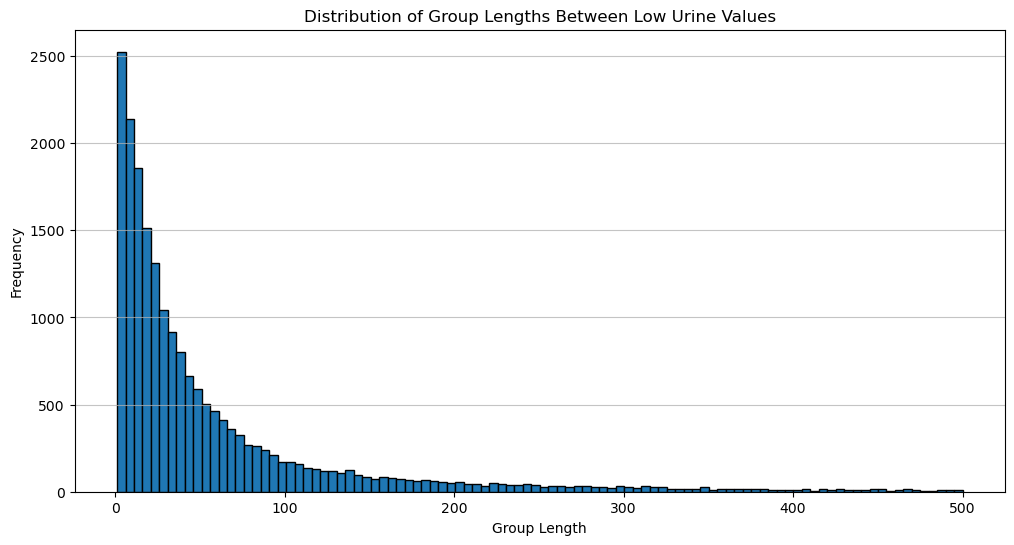

In [26]:
import pandas as pd
import matplotlib.pyplot as plt

# 读取 Sepsis_Dataset.csv 文件
sepsis_dataset = pd.read_csv('output/Sepsis_Dataset.csv')

# 找到 k 值为 'Low Urine' 的行
low_urine_indices = sepsis_dataset[sepsis_dataset['k'] == 'Low Urine'].index

# 计算组的长度
group_lengths = []
start_index = 0

for i in range(len(low_urine_indices)):
    if i == 0:
        # 第一个组的长度
        group_length = low_urine_indices[i] - start_index
    else:
        # 当前组的长度
        group_length = low_urine_indices[i] - low_urine_indices[i - 1] - 1
    
    if group_length > 0 and group_length <= 500:  # 只保留长度在500以内的组
        group_lengths.append(group_length)
    
    # 更新起始索引为当前的 Low Urine 行
    start_index = low_urine_indices[i] + 1
# 打印组的数量
print(f"序列数量: {len(group_lengths)}")
# 处理最后一组
if start_index < len(sepsis_dataset):
    group_length = len(sepsis_dataset) - start_index
    if group_length > 0 and group_length <= 500:  # 只保留长度在500以内的组
        group_lengths.append(group_length)
# 绘制直方图
plt.figure(figsize=(12, 6))
plt.hist(group_lengths, bins=100, edgecolor='black')  # 增加 bins 的数量并细化横距
plt.title('Distribution of Group Lengths Between Low Urine Values')
plt.xlabel('Group Length')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

In [13]:
import pandas as pd

# 读取 Sepsis_Targets_Raw.csv 文件
sepsis_targets_raw = pd.read_csv('output/Sepsis_Targets_Raw.csv')

# 统计唯一的 stay_id 数量
unique_stay_ids = sepsis_targets_raw['stay_id'].nunique()

# 打印结果
print(f"在 Sepsis_Targets_Raw.csv 中出现的唯一 stay_id 数量为: {unique_stay_ids}")

在 Sepsis_Targets_Raw.csv 中出现的唯一 stay_id 数量为: 11176


In [18]:
import pandas as pd

# 读取 Stroke_Dataset.csv 文件，跳过第一行
stroke_data = pd.read_csv('output/Sepsis_Dataset.csv', header=None, names=['id', 't', 'v', 'k'], skiprows=1)

# 将 t 列转换为浮点数
stroke_data['t'] = stroke_data['t'].astype(float)

# 初始化变量
sequences = []
current_sequence = []

# 遍历数据，识别序列
for index, row in stroke_data.iterrows():
    if row['k'] == 'Low Urine':
        if current_sequence:  # 如果当前序列不为空
            sequences.append(current_sequence)
        current_sequence = [row]  # 开始新的序列
    else:
        current_sequence.append(row)  # 添加到当前序列

# 处理最后一个序列（如果存在）
if current_sequence:
    sequences.append(current_sequence)

# 过滤掉时间跨度超过 14*24 小时的序列、长度小于2的序列，以及最后两行时间差为24的序列
filtered_sequences = []
for seq in sequences:
    if len(seq) >= 2 and (seq[-1]['t'] - seq[0]['t'] <= 14 * 24):
        # 检查最后两行的时间差是否为24
        if len(seq) >= 2 and (seq[-1]['t'] - seq[-2]['t'] != 24):
            filtered_sequences.append(seq)

# 将过滤后的序列展平为 DataFrame
filtered_data = pd.DataFrame([item for sublist in filtered_sequences for item in sublist])

# 保存结果到 StrokeDatasets.csv
output_file_path = 'output/SepsisDatasets.csv'
filtered_data.to_csv(output_file_path, index=False, header=False)

# 计算序列统计信息
sequence_lengths = [len(seq) for seq in filtered_sequences]
num_sequences = len(filtered_sequences)
average_length = sum(sequence_lengths) / num_sequences if num_sequences > 0 else 0
min_length = min(sequence_lengths) if sequence_lengths else 0
max_length = max(sequence_lengths) if sequence_lengths else 0

# 打印结果
print(f"处理后 SepsisDatasets.csv 的序列数量: {num_sequences}")
print(f"平均序列长度: {average_length:.2f}")
print(f"序列长度范围: [{min_length}, {max_length}]")

d:\Anaconda\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


处理后 SepsisDatasets.csv 的序列数量: 20081
平均序列长度: 68.46
序列长度范围: [2, 1406]


In [19]:
import pandas as pd

# 读取 StrokeDatasets.csv 文件
stroke_datasets = pd.read_csv('output/SepsisDatasets.csv')

# 过滤掉 k 值为 Middle_to_Sever 的数据
filtered_datasets = stroke_datasets[stroke_datasets['k'] != 'Low Urine']

# 统计不同的 k 值数量
unique_k_count = filtered_datasets['k'].nunique()

# 打印所有的 k 值
print("在 SepsisDatasets.csv 中所有的事件类型为:", filtered_datasets['k'].unique())

# 打印结果
print(f"在 SepsisDatasets.csv 中事件类型数量为: {unique_k_count}")

在 SepsisDatasets.csv 中所有的事件类型为: ['Respiratory Rate High' 'SpO2 Desat Limit Low' 'Hemoglobin Low'
 'WBC High' 'Prothrombin time High' 'PTT High' 'INR High' 'AST High'
 'BUN High' 'Total Bilirubin High' 'HCO3 Low' 'Albumin Low'
 'Platelet Count Low' 'Arterial CO2 Pressure Low' 'PH High'
 'Arterial Base Excess Low' 'Ionized Calcium Low' 'Sodium Low'
 'Arterial Blood Pressure diastolic Low'
 'Arterial Blood Pressure systolic Low' 'Magnesium High' 'ALT High'
 'Fibrinogen Low' 'Lactic Acid High' 'Magnesium Low'
 'Venous O2 Pressure High' 'Heart Rate Low'
 'Arterial Blood Pressure systolic High'
 'Arterial Blood Pressure mean High' 'Platelet Count High'
 'Arterial CO2 Pressure High' 'PH Low' 'Arterial Blood Pressure mean Low'
 'AST Low' 'Heart Rate High' 'Respiratory Rate Low'
 'Venous O2 Pressure Low' 'PTT Low' 'Chloride High' 'WBC Low'
 'Glucose High' 'Fibrinogen High' 'Potassium Low' 'Glucose Low'
 'HCO3 High' 'Arterial Base Excess High'
 'Arterial Blood Pressure diastolic High' 'Prothromb

In [20]:
import pandas as pd

df = pd.read_csv('./output/SepsisDatasets.csv')

# 提取所有不同的k值，并跳过值为Goal event的项
unique_k_values = df['k'].unique()

unique_k_values = [k for k in unique_k_values if k != 'Low Urine']

result_df = pd.DataFrame({
    'body_pred': unique_k_values,
    'index': range(len(unique_k_values))
})

result_df.to_csv('Sepsis_Body_Pred.csv', index=False)
print(result_df)


                body_pred  index
0   Respiratory Rate High      0
1    SpO2 Desat Limit Low      1
2          Hemoglobin Low      2
3                WBC High      3
4   Prothrombin time High      4
..                    ...    ...
61         Creatinine Low     61
62  SpO2 Desat Limit High     62
63           Albumin High     63
64                INR Low     64
65    Total Bilirubin Low     65

[66 rows x 2 columns]


In [21]:
import pandas as pd

# 读取 CoroheartDatasets.csv 文件
stroke_data = pd.read_csv('output/SepsisDatasets.csv')

# 提取唯一的 id
unique_ids = stroke_data['id'].unique()

# 计算分割点
split_index = int(len(unique_ids) * 0.8)

# 分割 id 为 ids1 和 ids2
ids1 = unique_ids[:split_index]
ids2 = unique_ids[split_index:]

# 根据 ids1 和 ids2 过滤数据
stroke_train = stroke_data[stroke_data['id'].isin(ids1)]
stroke_test = stroke_data[stroke_data['id'].isin(ids2)]

# 保存结果到 StrokeTrain.csv 和 StrokeTest.csv
stroke_train.to_csv('SepsisTrain.csv', index=False)
stroke_test.to_csv('SepsisTest.csv', index=False)

print(f"SepsisTrain.csv 和 SepsisTest.csv 已保存。")

SepsisTrain.csv 和 SepsisTest.csv 已保存。


In [22]:
import pandas as pd

test_df = pd.read_csv('SepsisTest.csv')
train_df = pd.read_csv('SepsisTrain.csv')
body_pred_df = pd.read_csv('Sepsis_Body_Pred.csv')

# 创建一个字典用于查找 body_pred 对应的 index
body_pred_to_index = body_pred_df.set_index('body_pred')['index'].to_dict()

# 定义一个函数来查找 index
def find_index(row):
    return body_pred_to_index.get(row['k'], None)

# 在 test 和 train 数据集中添加 index 列
test_df['index'] = test_df.apply(find_index, axis=1)
train_df['index'] = train_df.apply(find_index, axis=1)

test_df.to_csv('SepsisTestIndex.csv', index=False)
train_df.to_csv('SepsisTrainIndex.csv', index=False)

In [23]:
# 此处检查一下，是否存在 k 值不为 '1/2transfer3' 且 index 为 null 的行
test_index_df = pd.read_csv('SepsisTestIndex.csv')
train_index_df = pd.read_csv('SepsisTrainIndex.csv')

# 筛选出 k 值不为 '1/2transfer3' 且 index 为 null 的行
test_null_rows = test_index_df[(test_index_df['k'] != 'Low Urine') & (test_index_df['index'].isnull())]
train_null_rows = train_index_df[(train_index_df['k'] != 'Low Urine') & (train_index_df['index'].isnull())]

print(f"Test file null rows count: {len(test_null_rows)}")
print(f"Train file null rows count: {len(train_null_rows)}")

Test file null rows count: 0
Train file null rows count: 0


In [24]:
import numpy as np
import pandas as pd

# 定义一个非常大的数，如果一个谓词对应的事件没有发生，则用一个很大的数来表示
large_number = 1e10

def process_dataframe(file_path, output_path):
    df = pd.read_csv(file_path)
    
    result = []
    group = []
    for _, row in df.iterrows():
        if row['k'] == 'Low Urine':
            # 处理当前组
            if group:
                group_id = group[0]['id']
                # 初始化 body_predicates_time 数组
                body_predicates_time = [large_number] * 66
                # 填充 body_predicates_time 数组
                for item in group:
                    index = int(item['index'])
                    body_predicates_time[index] = item['t']
                # If body_predicates_time is all large_number, skip this group
                if all(time == large_number for time in body_predicates_time):
                    continue
                # 获取 head_predicate_time
                head_predicate_time = [row['t']]
                # 添加到结果
                result.append({
                    'id': group_id,
                    'body_predicates_time': body_predicates_time,
                    'head_predicate_time': head_predicate_time
                })
            group = []
        else:
            group.append(row)
    
    np.save(output_path, result)
    # 输出分组数
    print(f"{file_path} 数据集总共有 {len(result)} 组")
    # 打印前两个结果
    print(f"前两个结果: {result[:2]}")

# 处理测试集和训练集
process_dataframe('SepsisTestIndex.csv', 'SepsisTestData.npy')
process_dataframe('SepsisTrainIndex.csv', 'SepsisTrainData.npy')


SepsisTestIndex.csv 数据集总共有 3857 组
前两个结果: [{'id': 37693441, 'body_predicates_time': [39.31666666666667, 39.31666666666667, 35.21666666666667, 35.21666666666667, 10000000000.0, 35.15, 10000000000.0, 10000000000.0, 21.316666666666663, 10000000000.0, 3.683333333333333, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 24.316666666666663, 10000000000.0, 10000000000.0, 35.21666666666667, 10000000000.0, 10000000000.0, 10000000000.0, 21.316666666666663, 2.316666666666667, 5.366666666666666, 10000000000.0, 21.316666666666663, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10

In [1]:
import numpy as np

# 加载 .npy 文件
train_data = np.load('SepsisTrainData.npy', allow_pickle=True)
test_data = np.load('SepsisTestData.npy', allow_pickle=True)

def filter_data(data):
    filtered_data = []
    for group in data:
        # 假设每组数据是一个字典，包含 'id', 'body_predicates_time', 'head_predicate_time'
        body_predicates_time = group['body_predicates_time']
        head_predicate_time = float(group['head_predicate_time'][0])  # 将 head_predicate_time 转换为数字
        
        # 找到 body_predicates_time 中的最大值，且不等于 10000000000.0
        max_body_time = max(float(time) for time in body_predicates_time if float(time) != 10000000000.0)  # 将 body_predicates_time 中的值转换为数字
        
        # 检查条件
        if max_body_time + 24 >= head_predicate_time:
            filtered_data.append(group)
    
    return filtered_data

# 过滤数据
filtered_train_data = filter_data(train_data)
filtered_test_data = filter_data(test_data)

# 保存过滤后的数据
np.save('SepsisTrain.npy', filtered_train_data)
np.save('SepsisTest.npy', filtered_test_data)

# 打印结果
print(f"SepsisTrain.npy 中的组数: {len(filtered_train_data)}")
print(f"SepsisTest.npy 中的组数: {len(filtered_test_data)}")

# 打印前两个组
print("SepsisTrain.npy 前两个组:", filtered_train_data[:2])
print("SepsisTest.npy 前两个组:", filtered_test_data[:2])

d:\Anaconda\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


SepsisTrain.npy 中的组数: 16159
SepsisTest.npy 中的组数: 3842
SepsisTrain.npy 前两个组: [{'id': 30001446, 'body_predicates_time': [11.183333333333334, 7.716666666666667, 10.25, 10.25, 10.266666666666667, 10.266666666666667, 10.266666666666667, 10.266666666666667, 10.266666666666667, 10.266666666666667, 10.266666666666667, 1.7, 10.25, 3.4166666666666665, 3.4166666666666665, 3.4166666666666665, 3.4166666666666665, 3.4166666666666665, 11.183333333333334, 7.183333333333334, 10.266666666666667, 10.266666666666667, 10.266666666666667, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.